<img src="images/dask_horizontal.svg"
     width="45%"
     alt="Dask logo\">
     
# Dask Delayed

This notebook covers Dask's `delayed` interface and how it can be used to parallelize existing Python code and custom algorithms. Let's start by looking at a basic, non-parallelized example and then see how `dask.delayed` can help.

# Basic example

In the code cell below, we have two Python functions, `inc` and `add`, which increment and add together their inputs, respectively. We call these functions on input values to produce some output which we then print.

*Tip*: the `%%time` at the top of the cell tells Jupyter to print out how long it took the cell to run.

In [1]:
%%time

import time

def inc(i):
    time.sleep(1)
    return i + 1

def add(a, b):
    time.sleep(1)
    return a + b

a = 1
b = 12

# Increment a and b
c = inc(a)
d = inc(b)

# Add results together
output = add(c, d)

print(f"{output = }")

output = 15
Wall time: 3.03 s


The steps in this computation can be encoded in the following task graph shown below

![](images/inc-add.svg)

In the above task graph:

1. Circular nodes in the graph are Python function calls

2. Square nodes are Python objects that are created by one task as output and can be used as inputs in another task

3. Arrows represent dependencies between tasks

From looking at the task graph, we can see there's an opportunity for parallelism here! The two `inc` calls are totally independent of one another, so they could be run at the same time in parallel. Let's see how we can use Dask's `delayed` interface to do this.

# `dask.delayed` decorator

Dask's `delayed` interface consists of a single `delayed` decorator which allows you to build up complex task graphs by lightly annotating normal Python functions. Dask can then execute the task graph (potentially in parallel). The idea is that you can take your existing Python code, apply a few `delayed` decorators, and then have a parallel version of your code.

Let's revist our `inc` / `add` example from before:

In [2]:
%%time

import time
from dask import delayed    # Import the delayed decorator

@delayed                    # Wrap inc with delayed
def inc(i):
    time.sleep(1)
    return i + 1

@delayed                    # Wrap add with delayed
def add(a, b):
    time.sleep(1)
    return a + b

a = 1
b = 12

# Increment a and b
c = inc(a)
d = inc(b)

# Add results together
output = add(c, d)

print(f"{output = }")

output = Delayed('add-be375171-eb49-4986-96b9-977d13ec0476')
Wall time: 281 ms


That happened much faster! But notice that the above cell didn't print the expected result of `15`, instead it printed a `Delayed` object.

That's because Dask `delayed` works by wraping function calls and **delaying their execution** (hence the name "delayed"). Instead of returning the result of a function call, `delayed` functions return `Delayed` objects which keep track of what we want to compute by automatically building a task graph for us.

You can see the task graph for a `Delayed` object by calling its `visualize` method:

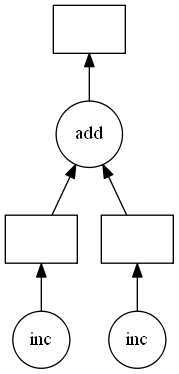

In [3]:
output.visualize()

To actually compute a result of a `Delayed` object, call its `compute` method which will tell Dask to compute the task graph in parallel.

In [4]:
%%time

# Compute result
result = output.compute()
print(f"{result = }")

result = 15
Wall time: 2.05 s


Notice that the parallel version of this computation took ~2s while the non-parallel version took ~3s. Why do you think that is?

``Delayed`` objects support several standard Python operations, each of which creates another ``Delayed`` object representing the result:

- Arithamtic operators, e.g. `*`, `-`, `+`
- Item access and slicing, e.g. `x[0]`, `x[1:3]`
- Attribute access, e.g. `x.size`
- Method calls, e.g. `x.index(0)`

Using `delayed` functions, we can easily build up a task graph for the particular computation we want to perform.

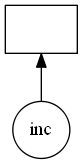

In [5]:
result = inc(5)
result.visualize()

In [6]:
result.compute()

6

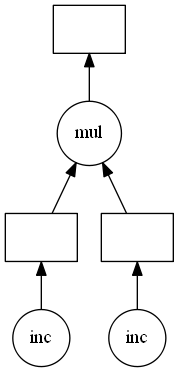

In [7]:
result = inc(5) * inc(7)
result.visualize()

In [8]:
result.compute()

48

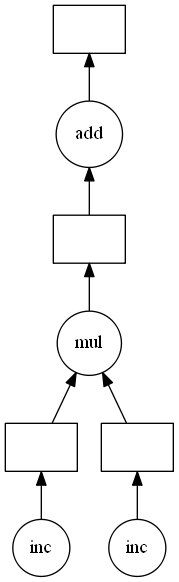

In [9]:
result = (inc(5) * inc(7)) + 2
result.visualize()

In [10]:
result.compute()

50

# Exercise 1: Parallelize a for-loop

Below we define three functions: `inc`, `double`, and `add`. We use these functions to perform some operations on a list (assigned to the `data` variable). For this exercise, use `delayed` to run these operations in parallel.

In [11]:
%%time

import time

def inc(x):
    time.sleep(0.5)
    return x + 1

def double(x):
    time.sleep(0.5)
    return 2 * x

def add(x, y):
    time.sleep(0.5)
    return x + y

data = list(range(10))

output = []
for x in data:
    a = inc(x)
    b = double(x)
    c = add(a, b)
    output.append(c)

total = sum(output)
total

Wall time: 15 s


145

Wall time: 2.51 s


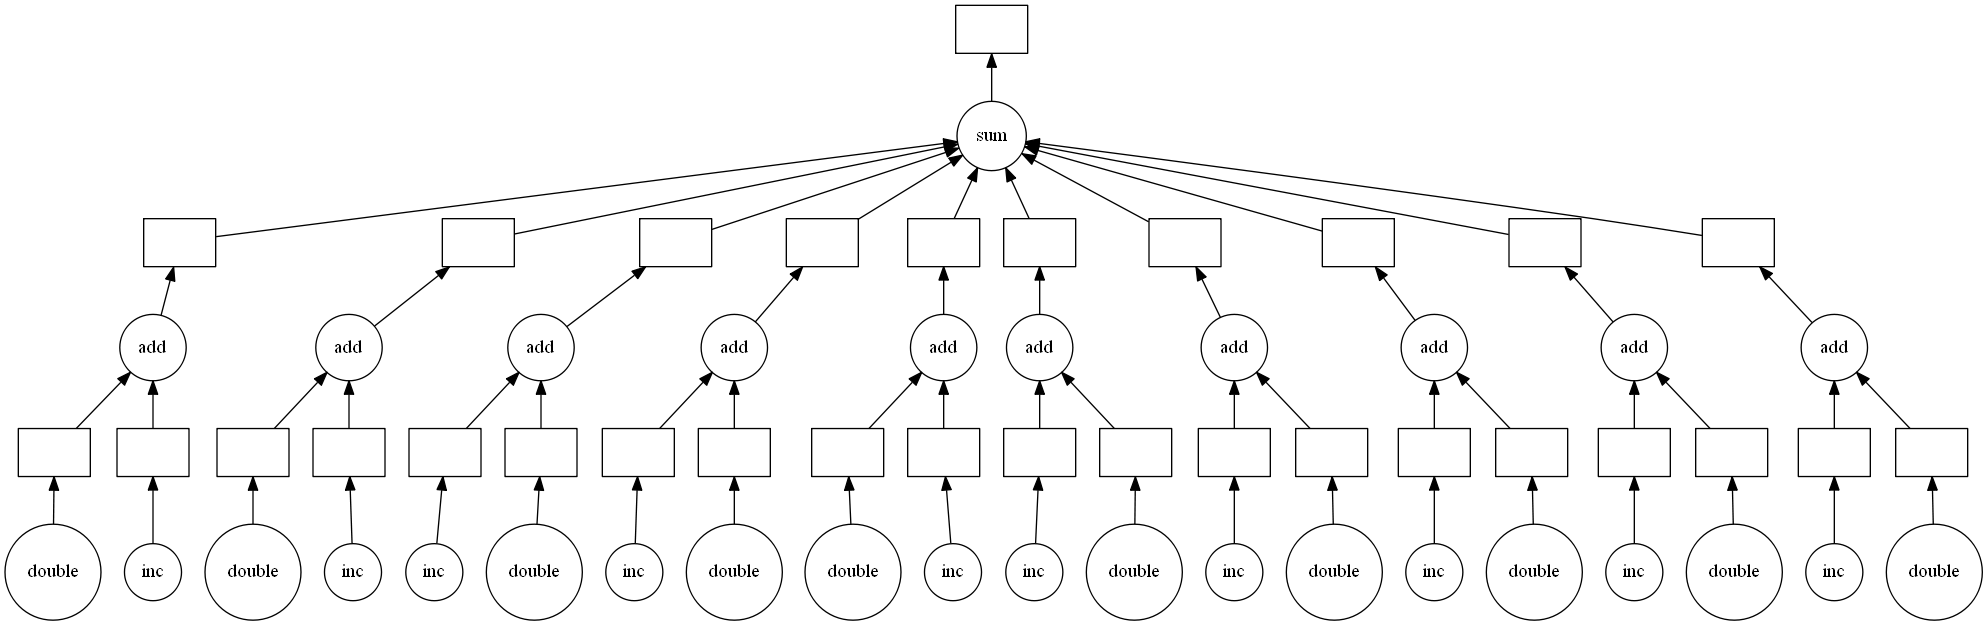

In [21]:
# Your solution here


import time

@delayed
def inc(x):
    time.sleep(0.5)
    return x + 1

@delayed
def double(x):
    time.sleep(0.5)
    return 2 * x

@delayed
def add(x, y):
    time.sleep(0.5)
    return x + y

data = list(range(10))

output = []
for x in data:
    a = inc(x)
    b = double(x)
    c = add(a, b)
    output.append(c)
    
total = delayed(sum)(output)
%time total.compute()
total.visualize()

Wall time: 2.51 s


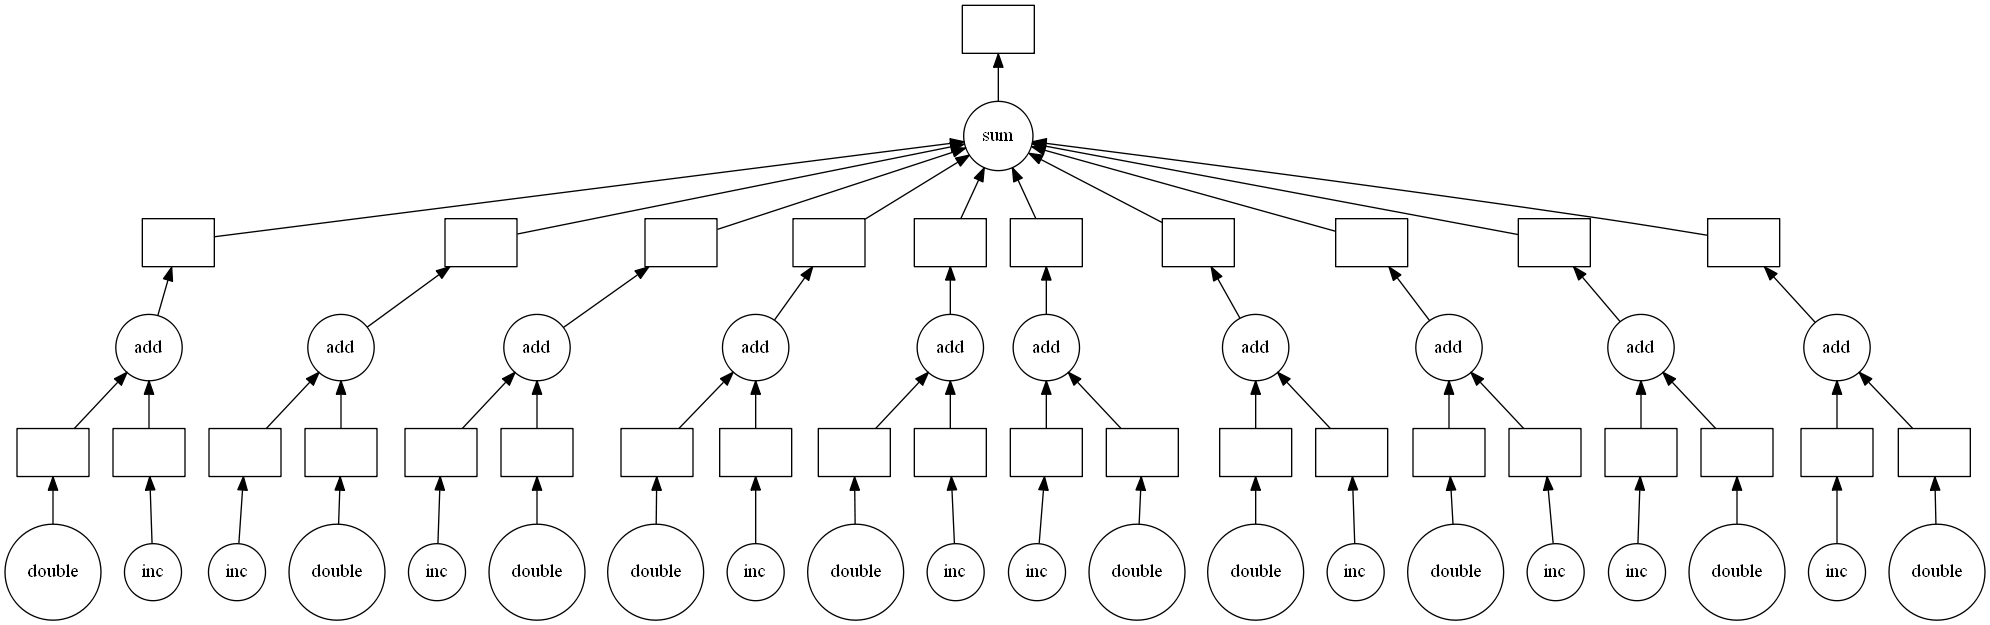

In [19]:
# %load solutions/delayed-1.py
import time
from dask import delayed

@delayed
def inc(x):
    time.sleep(0.5)
    return x + 1

@delayed
def double(x):
    time.sleep(0.5)
    return 2 * x

@delayed
def add(x, y):
    time.sleep(0.5)
    return x + y

data = list(range(10))

output = []
for x in data:
    a = inc(x)
    b = double(x)
    c = add(a, b)
    output.append(c)

total = delayed(sum)(output)
%time total.compute()

# Exercise 2: Parallelize a for-loop with conditional flow

This exercise is similar to the previous, but now instead of always having `a = inc(x)` we sometimes increment `x` and sometimes double `x` depending on if `x` is an even number or not. For this exercise, we again want to use `delayed` to run these operations in parallel.

In [5]:
import time

def inc(x):
    time.sleep(0.5)
    return x + 1

def double(x):
    time.sleep(0.5)
    return 2 * x

def add(x, y):
    time.sleep(0.5)
    return x + y

def is_even(x):
    return not x % 2

In [6]:
%%time

data = list(range(10))

output = []
for x in data:
    if is_even(x):
        a = inc(x)
    else:
        a = double(x)
    b = double(x)
    c = add(a, b)
    output.append(c)

total = sum(output)
total

Wall time: 15.3 s


165

In [7]:
# Your solution here

data = list(range(10))

output = []
for x in data:
    if is_even(x):
        a = delayed(inc)(x)
    else:
        a = delayed(double)(x)
    b = delayed(double)(x)
    c = delayed(add)(a, b)
    output.append(c)

total = delayed(sum)(output)
%time total.compute()

Wall time: 2.58 s


165

In [27]:
# %load solutions/delayed-2.py

import time
from dask import delayed

@delayed
def inc(x):
    time.sleep(0.5)
    return x + 1

@delayed
def double(x):
    time.sleep(0.5)
    return 2 * x

@delayed
def add(x, y):
    time.sleep(0.5)
    return x + y

def is_even(x):
    return not x % 2

data = list(range(10))

output = []
for x in data:
    if is_even(x):
        a = inc(x)
    else:
        a = double(x)
    b = double(x)
    c = add(a, b)
    output.append(c)

total = delayed(sum)(output)
%time total.compute()

Wall time: 2.51 s


165

# Exercise 3: Parallelize Pandas' `read_csv`

For this exercise we'll use CSV files from NYC's flight dataset. You can download the CSV files by running the cell below.

In [8]:
# Run this cell to download NYC flight dataset
%run prep.py -d flights

We can then use Python's `glob` module to get a list of all the CSV files in the dataset:

In [9]:
import glob

files = glob.glob("data/nycflights/*.csv")
files

['data/nycflights\\1990.csv',
 'data/nycflights\\1991.csv',
 'data/nycflights\\1992.csv',
 'data/nycflights\\1993.csv',
 'data/nycflights\\1994.csv',
 'data/nycflights\\1995.csv',
 'data/nycflights\\1996.csv',
 'data/nycflights\\1997.csv',
 'data/nycflights\\1998.csv',
 'data/nycflights\\1999.csv']

[Pandas' `read_csv` function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) can be used to load a single CSV file for our datset:

In [10]:
import pandas as pd

In [11]:
%%time

df = pd.read_csv(files[0])
df

Wall time: 515 ms


,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990,1,1,1,1621.0,1540,1747.0,1701,US,33,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1990,1,2,2,1547.0,1540,1700.0,1701,US,33,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1990,1,3,3,1546.0,1540,1710.0,1701,US,33,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0,0
3,1990,1,4,4,1542.0,1540,1710.0,1701,US,33,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,0,0
4,1990,1,5,5,1549.0,1540,1706.0,1701,US,33,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271534,1990,12,27,4,1645.0,1535,2001.0,1759,DL,223,...,NaN,122.0,70.0,LGA,ATL,761.0,NaN,NaN,0,0
271535,1990,12,28,5,1934.0,1535,2205.0,1759,DL,223,...,NaN,246.0,239.0,LGA,ATL,761.0,NaN,NaN,0,0
271536,1990,12,29,6,1557.0,1535,1931.0,1759,DL,223,...,NaN,92.0,22.0,LGA,ATL,761.0,NaN,NaN,0,0
271537,1990,12,30,7,1548.0,1535,1832.0,1759,DL,223,...,NaN,33.0,13.0,LGA,ATL,761.0,NaN,NaN,0,0


The goal of this exercise is to use `dask.delayed` to create a new `read_csv_parallel` function which reads in *all* the files in the dataset in parallel using `dask.delayed`.

In [15]:
# Your solution here

read_csv_delayed = delayed(pd.read_csv)

def read_csv_parallel(files):
    dfs = [read_csv_delayed(f) for f in files]
        
    final = delayed(pd.concat)(dfs)
    return final

df = read_csv_parallel(files)
%time df.compute()
# df.visualize()

Wall time: 3.23 s


,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990,1,1,1,1621.0,1540,1747.0,1701,US,33,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1990,1,2,2,1547.0,1540,1700.0,1701,US,33,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1990,1,3,3,1546.0,1540,1710.0,1701,US,33,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0,0
3,1990,1,4,4,1542.0,1540,1710.0,1701,US,33,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,0,0
4,1990,1,5,5,1549.0,1540,1706.0,1701,US,33,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269176,1999,12,27,1,1645.0,1645,1830.0,1901,UA,1753,...,205.0,-31.0,0.0,LGA,DEN,1619.0,7.0,13.0,0,0
269177,1999,12,28,2,1726.0,1645,1928.0,1901,UA,1753,...,214.0,27.0,41.0,LGA,DEN,1619.0,5.0,23.0,0,0
269178,1999,12,29,3,1646.0,1645,1846.0,1901,UA,1753,...,220.0,-15.0,1.0,LGA,DEN,1619.0,5.0,15.0,0,0
269179,1999,12,30,4,1651.0,1645,1908.0,1901,UA,1753,...,233.0,7.0,6.0,LGA,DEN,1619.0,5.0,19.0,0,0


In [13]:
# %load solutions/delayed-3.py

import glob
import pandas as pd
from dask import delayed

# Use delayed to make a lazy version of Pandas' read_csv
read_csv_delayed = delayed(pd.read_csv)

def read_csv_parallel(files):
    # Lazily load each CSV file
    dfs = [read_csv_delayed(f) for f in files]
    # Concatenate the DataFrame pieces into a single DataFrame
    df = delayed(pd.concat)(dfs)
    return df

# Get list of CSV files and load them in paralell
files = glob.glob("data/nycflights/*.csv")
df = read_csv_parallel(files)
%time df.compute()

Wall time: 3.73 s


,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990,1,1,1,1621.0,1540,1747.0,1701,US,33,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1990,1,2,2,1547.0,1540,1700.0,1701,US,33,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1990,1,3,3,1546.0,1540,1710.0,1701,US,33,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0,0
3,1990,1,4,4,1542.0,1540,1710.0,1701,US,33,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,0,0
4,1990,1,5,5,1549.0,1540,1706.0,1701,US,33,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269176,1999,12,27,1,1645.0,1645,1830.0,1901,UA,1753,...,205.0,-31.0,0.0,LGA,DEN,1619.0,7.0,13.0,0,0
269177,1999,12,28,2,1726.0,1645,1928.0,1901,UA,1753,...,214.0,27.0,41.0,LGA,DEN,1619.0,5.0,23.0,0,0
269178,1999,12,29,3,1646.0,1645,1846.0,1901,UA,1753,...,220.0,-15.0,1.0,LGA,DEN,1619.0,5.0,15.0,0,0
269179,1999,12,30,4,1651.0,1645,1908.0,1901,UA,1753,...,233.0,7.0,6.0,LGA,DEN,1619.0,5.0,19.0,0,0


# Additional Resources

- [Delayed documentation](https://docs.dask.org/en/latest/delayed.html)
- [Delayed screencast](https://www.youtube.com/watch?v=SHqFmynRxVU)
- [Delayed API](https://docs.dask.org/en/latest/delayed-api.html)
- [Delayed examples](https://examples.dask.org/delayed.html)
- [Delayed best practices](https://docs.dask.org/en/latest/delayed-best-practices.html)

# Next steps

Next, we'll move onto discussing [Dask DataFrames](2-dataframe.ipynb)